In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import create_y_data
from bo_functions import bo_iter
from bo_functions import test_train_split
from bo_functions import bo_iter_w_runs

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 82

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 3
train_iter = 300
noise_std = 0.1
runs = 2
explore_bias = torch.tensor([0.75])
t=4
shuffle_seed = 6
set_lengthscale = np.array([None])

emulator = True
sparse_grid = True
verbose = False
save_fig=False

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays

Runs: 2
BO Iters: 3
------------------------------
Run Number:  1


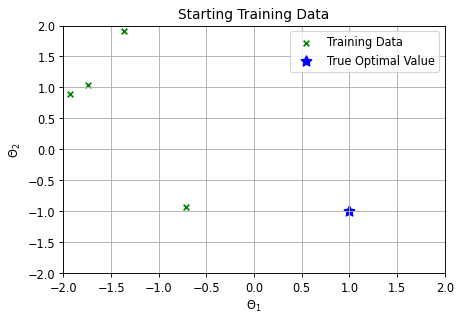

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


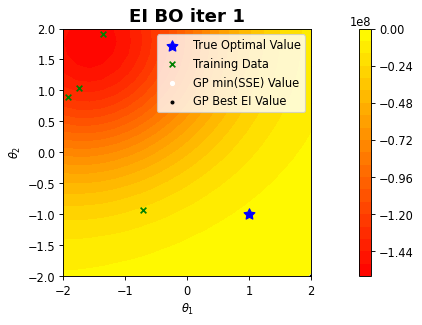

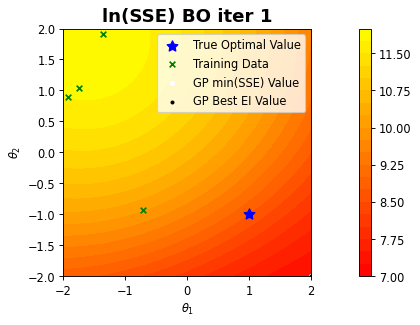

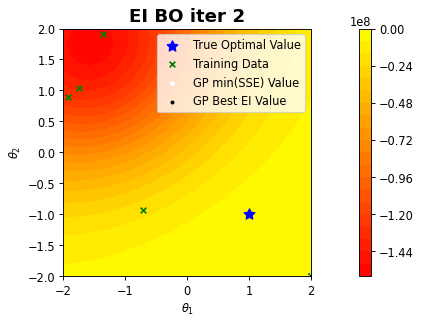

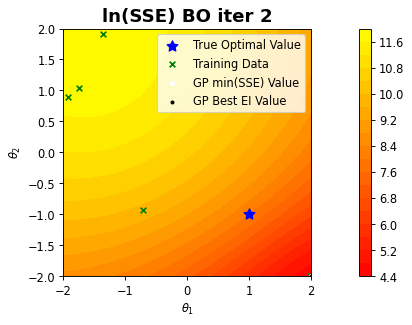

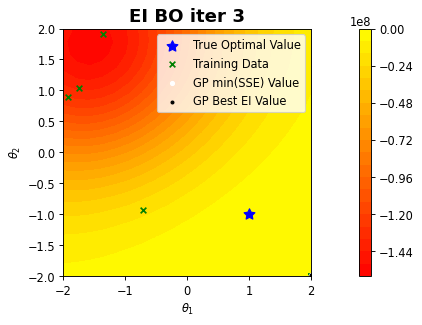

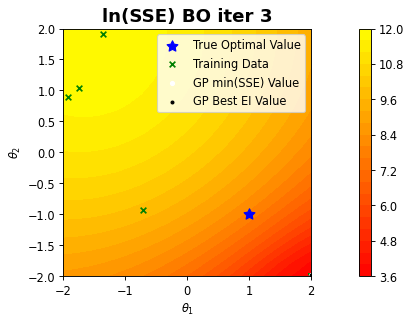

Run Number:  2


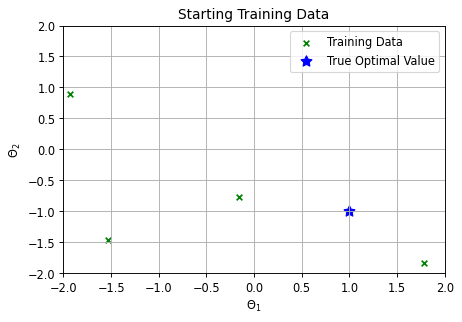

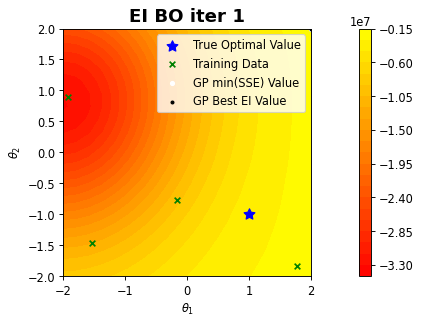

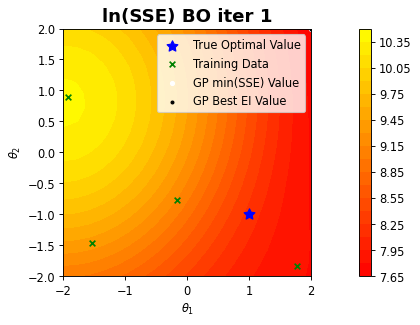

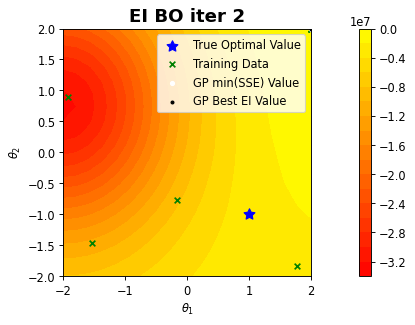

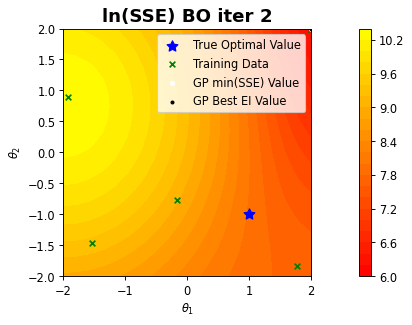

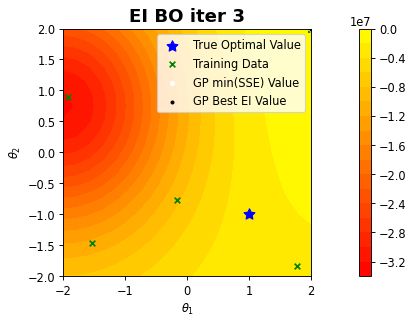

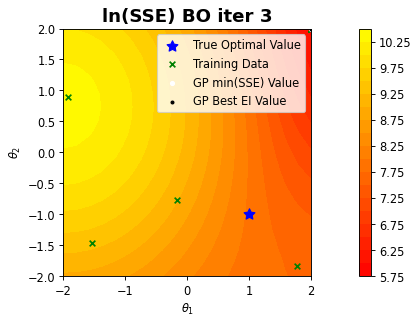

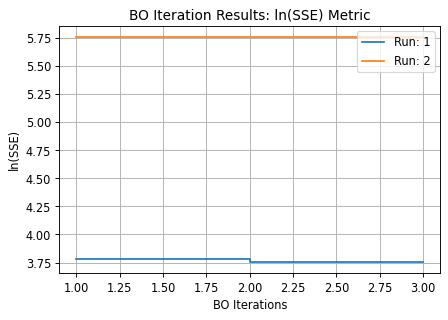

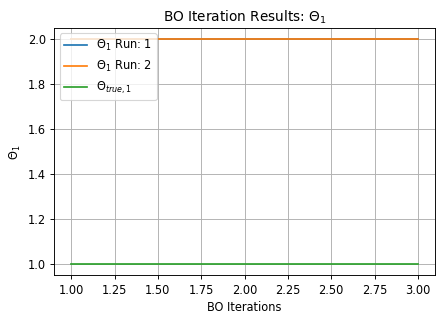

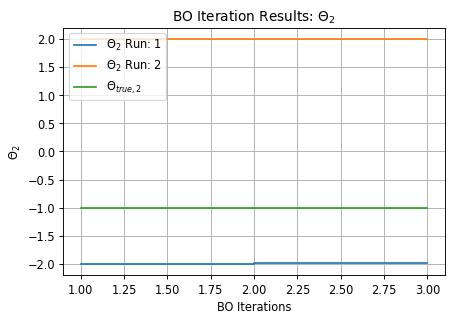

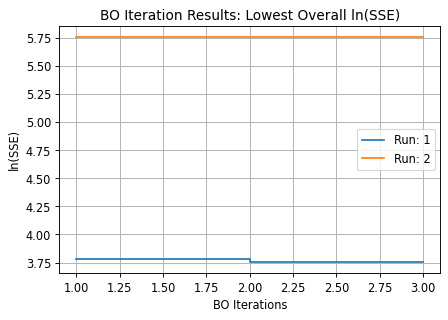

The GP predicts the lowest SSE of 4.272e+01 occurs at θ = [ 2.         -1.98255616] during run 1 at BO iteration 3
At this point, the highest EI occurs at θ = [ 2.         -1.98320255]
CPU times: user 1min 20s, sys: 225 ms, total: 1min 20s
Wall time: 1min 21s


In [3]:
%%time
obj = "obj"

all_data_doc = "Input_CSVs/Train_Data/all_2_data/t=25.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))  

print("Runs:", runs)
print("BO Iters:",BO_iters)
print("------------------------------")
for i in range(len(set_lengthscale)):
    for j in range(len(explore_bias)):
        results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[j], Xexp, Yexp,
                                     noise_std, obj, runs, sparse_grid, emulator, set_lengthscale[i], verbose, 
                                     save_fig, shuffle_seed)
        print("The GP predicts the lowest SSE of", "{:.3e}".format(np.exp(results[3])), "occurs at \u03B8 =", results[2][0], 
                  "during run", results[1], "at BO iteration", results[0])
        print("At this point, the highest EI occurs at \u03B8 =", results[4][0])